
<br>
Title: Timeseries satellite telemetry anomaly detection using an Autoencoder<br>
Author: Chuck Jackel - based on original code by [pavithrasv](https://github.com/pavithrasv)<br>
Date created: 2022/10/6/2022<br>
Last modified: 2022/10/9/2022<br>
Description: Detect anomalies in a satellite telemetry timeseries using an Autoencoder.<br>



<br>
##Introduction<br>
This script demonstrates how to use a reconstruction convolutional<br>
autoencoder model to detect anomalies in timeseries satellite telemetry data.<br>



<br>
## Setup<br>


In [32]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pandas import read_csv
import tensorflow as tf
import random as python_random

PYTHONHASHSEED=0

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(222)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(222)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(333)


<br>
## Load the data<br>
Satellite bus voltage telemetry from the Laboratory for Atmospheric Sciences and Physics (LASP) at University of Colorado Boulder is used for this demonstration. The data is located on Shawn Polson's github page at https://github.com/sapols/Satellite-Telemetry-Anomaly-Detection/tree/master/Data. <br>
<br> It is unknown if any of the data is anomalous. However, there are spikes in the data that suggest possible anomalies, so the various experiments with data preparation impacted how the model performed.<br>
<br>In this demonstration, the latter 2/3 section of the original data was used to train the model. This was done to eliminate the 20 volt spike near the year 2005 as part of the training data.<br>

In [2]:
#master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
#master_url_root = "https://raw.githubusercontent.com/sapols/Satellite-Telemetry-Anomaly-Detection/master/Data/"
master_url_root = "https://raw.githubusercontent.com/cjackel29/ece551/"

In [3]:
#df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url_suffix = "main/busvoltage_without_anomaly.csv"
#df_small_noise_url_suffix = "main/busvoltage_trim_without_anomaly.csv"
#df_small_noise_url_suffix = "main/busvoltage_spike_removed.csv"
#df_small_noise_url_suffix = "main/BusVoltage_encoded_2.csv"
#df_small_noise_url_suffix = "main/busvoltage_smoothed_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
   df_small_noise_url, parse_dates=True, index_col=0)
df_small_noise_original = df_small_noise
df_small_noise_quarter = df_small_noise[:12926]
df_small_noise_firsthalf = df_small_noise[:25852]# 25852 is 50% 
df_small_noise_secondhalf = df_small_noise[25852:]# 12926 is 25% 20282 is Jan 1, 2008
df_small_noise_section = df_small_noise[16546:]
#df_small_noise = df_small_noise_secondhalf
#df_small_noise = df_small_noise_firsthalf
df_small_noise = df_small_noise_section
#df_small_noise = pd.read_csv('art_daily_small_noise.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")
#df_small_noise = pd.read_csv('busvoltage_original.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")

In [4]:
master_url_root = "https://raw.githubusercontent.com/cjackel29/ece551/"

#df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url_suffix = "main/busvoltage_without_anomaly.csv"
#df_daily_jumpsup_url_suffix = "main/busvoltage_with_anomaly.csv"
#df_daily_jumpsup_url_suffix = "main/BusVoltage_not_encoded_1.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col=0)
#df_daily_jumpsup = pd.read_csv('art_daily_jumpsup.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")
#df_daily_jumpsup = pd.read_csv('busvoltage_with_anomaly.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")

In [5]:
print(df_small_noise.head())
df_small_noise.shape

                     busvoltage
datetime                       
2006-09-21 03:00:00   32.544468
2006-09-21 06:00:00   32.587519
2006-09-21 09:00:00   32.497483
2006-09-21 12:00:00   32.561844
2006-09-21 15:00:00   32.573050


(35158, 1)

In [6]:
print(df_daily_jumpsup.head())
df_daily_jumpsup.shape

                     busvoltage
datetime                       
2001-01-21 21:00:00   32.003189
2001-01-22 00:00:00   31.943952
2001-01-22 03:00:00   32.102344
2001-01-22 06:00:00   31.988111
2001-01-22 09:00:00   31.945055


(51704, 1)


<br>The satellite telemetry from approximately 2008 through 2018 is used for training data.<br>


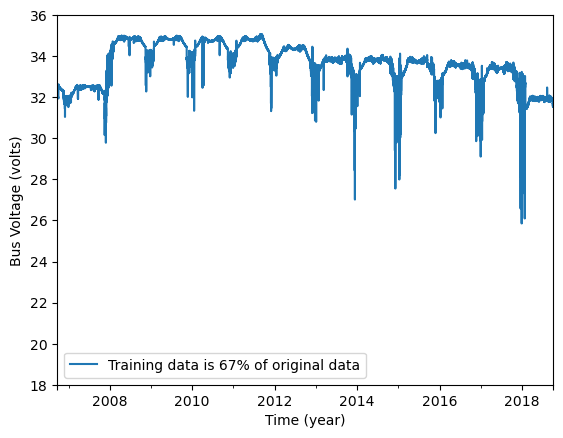

In [7]:
fig, ax = plt.subplots()
df_small_noise.plot(ax=ax)
plt.legend(["Training data is {}% of original data".format(int(100*df_small_noise.shape[0]/df_small_noise_original.shape[0]))])
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()

<br>The entire satellite bus voltage telemetry from 2001 to 2018 has numerous spikes including a 20 volt drop near 2005. Let us see if the model will detect any of the spikes as an anomaly.<br>


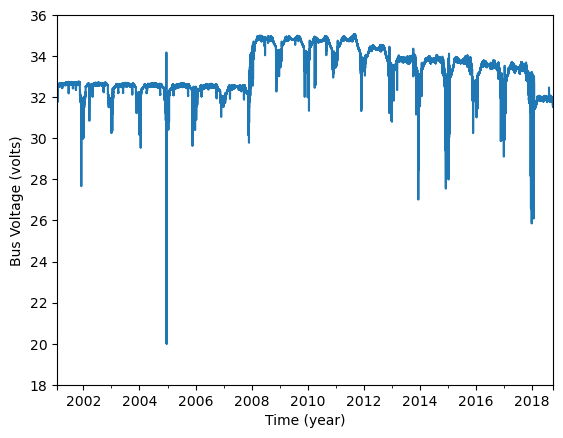

In [8]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()


<br>
## Prepare training data<br>
Get data values from the training timeseries data file and normalize the<br>
`value` data. We have a `value` for every 5 mins for 14 days.<br>
-   24 * 60 / 5 = **288 timesteps per day**<br>
-   288 * 14 = **4032 data points** in total<br>


Normalize and save the mean and std we get,<br>
for normalizing test data.

In [9]:
training_mean = df_small_noise.mean()
#training_mean = df_small_noise_secondhalf.mean()
#training_mean = df_small_noise_firsthalf.mean()
training_std = df_small_noise.std()
#training_std = df_small_noise_secondhalf.std()
#training_std = df_small_noise_firsthalf.std()
df_training_value = (df_small_noise - training_mean) / training_std
#df_training_value = (df_small_noise_secondhalf - training_mean) / training_std
#df_training_value = (df_small_noise_firsthalf - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 35158



<br>
### Create sequences<br>
Create sequences combining `TIME_STEPS` contiguous data values from the<br>
training data.<br>


In [10]:
TIME_STEPS = 8 # each measurement is taken every 3 hours, so there are 8 samples per day, 56 samples per week, 2912 per year

Generated training sequences for use in the model.

In [11]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [12]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (35151, 8, 1)



<br>
## Build a model<br>
We will build a convolutional reconstruction autoencoder model. The model will<br>
take input of shape `(batch_size, sequence_length, num_features)` and return<br>
output of the same shape. In this case, `sequence_length` is 288 and<br>
`num_features` is 1.<br>


In [13]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             256       
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 16)             3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 16)            1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 4, 16)             0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 8, 32)            3616      
 ranspose)                                              

2022-10-09 08:01:01.867365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 08:01:01.867418: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 08:01:01.867461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-09 08:01:01.867770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



<br>
## Train the model<br>
Please note that we are using `x_train` as both the input and the target<br>
since this is a reconstruction model.<br>


In [14]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, mode="min")
    ],
)

Epoch 1/100
248/248 [==============================] - 3s 8ms/step - loss: 0.1078 - val_loss: 0.0931
Epoch 2/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0281 - val_loss: 0.0933
Epoch 3/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0235 - val_loss: 0.0810
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0188 - val_loss: 0.0610
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0160 - val_loss: 0.0735
Epoch 6/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0144 - val_loss: 0.0754
Epoch 7/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0128 - val_loss: 0.0858
Epoch 8/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0120 - val_loss: 0.0769
Epoch 9/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0111 - val_loss: 0.0900
Epoch 10/100
248/248 [==============================] - 2s 8ms/step - loss: 0.0101 - val_lo

248/248 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 0.0743
Epoch 82/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0034 - val_loss: 0.0582
Epoch 83/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0033 - val_loss: 0.0571
Epoch 84/100
248/248 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 0.0488
Epoch 85/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0525
Epoch 86/100
248/248 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0602
Epoch 87/100
248/248 [==============================] - 3s 10ms/step - loss: 0.0031 - val_loss: 0.0529
Epoch 88/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0034 - val_loss: 0.0595
Epoch 89/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 0.0610
Epoch 90/100
248/248 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss:


<br>
Let's plot training and validation loss to see how the training went.<br>


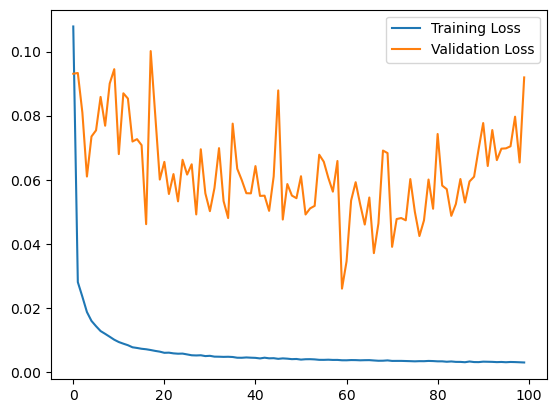

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


<br>
## Detecting anomalies<br>
We will detect anomalies by determining how well our model can reconstruct<br>
the input data.<br>
1.   Find MAE loss on training samples.<br>
2.   Find max MAE loss value. This is the worst our model has performed trying<br>
to reconstruct a sample. We will make this the `threshold` for anomaly<br>
detection.<br>
3.   If the reconstruction loss for a sample is greater than this `threshold`<br>
value then we can infer that the model is seeing a pattern that it isn't<br>
familiar with. We will label this sample as an `anomaly`.<br>


Get train MAE loss.

In [16]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

1099/1099 [==============================] - 3s 2ms/step


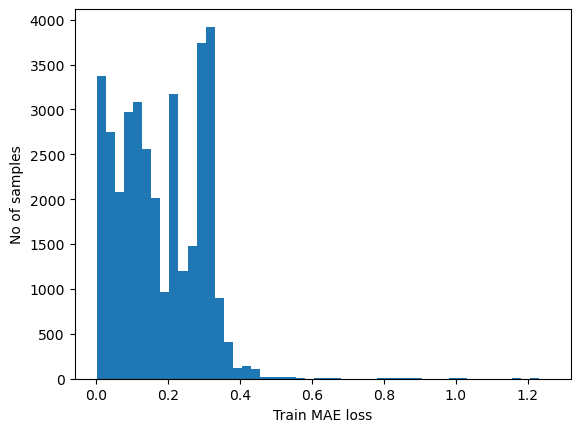

In [17]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

Get reconstruction loss threshold.

In [18]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  1.2565918789405508



<br>
### Compare recontruction<br>
Just for fun, let's see how our model has recontructed the first sample.<br>
This is the 288 timesteps from day 1 of our training dataset.<br>


Checking how the first sequence is learnt

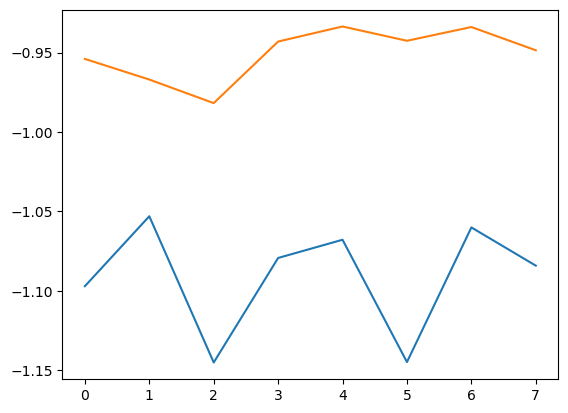

In [19]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


<br>
### Prepare test data<br>


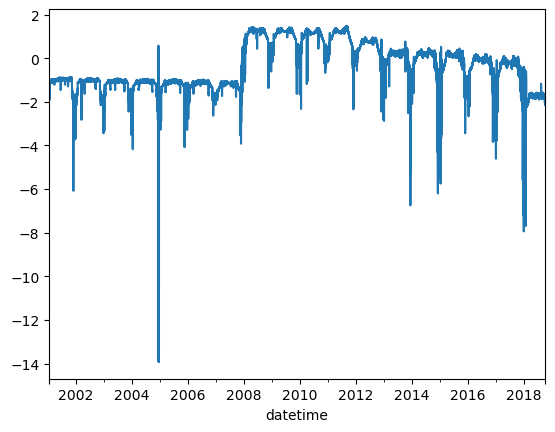

In [20]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

Create sequences from test values.

In [21]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


Test input shape:  (51697, 8, 1)


In [22]:
x_test

array([[[-1.65074097],
        [-1.71132745],
        [-1.54932626],
        ...,
        [-1.79346957],
        [-1.60413133],
        [-1.51575621]],

       [[-1.71132745],
        [-1.54932626],
        [-1.66616185],
        ...,
        [-1.60413133],
        [-1.51575621],
        [-1.78561805]],

       [[-1.54932626],
        [-1.66616185],
        [-1.71019881],
        ...,
        [-1.51575621],
        [-1.78561805],
        [-1.62394403]],

       ...,

       [[-2.09144638],
        [-2.12608137],
        [-2.10815577],
        ...,
        [-2.10172053],
        [-2.12408841],
        [-2.09511221]],

       [[-2.12608137],
        [-2.10815577],
        [-2.10292514],
        ...,
        [-2.12408841],
        [-2.09511221],
        [-2.11174561]],

       [[-2.10815577],
        [-2.10292514],
        [-2.09609023],
        ...,
        [-2.09511221],
        [-2.11174561],
        [-2.12841694]]])

Get test MAE loss.

In [23]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

1616/1616 [==============================] - 4s 2ms/step


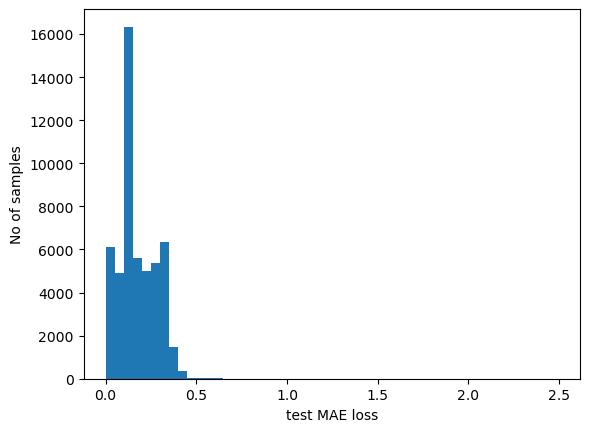

In [24]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

Detect all the samples which are anomalies.

In [25]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  17
Indices of anomaly samples:  (array([11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414,
       11415, 11447, 11448, 11449, 11450, 11451, 11452, 11453]),)



<br>
## Plot anomalies<br>
We now know the samples of the data which are anomalies. With this, we will<br>
find the corresponding `timestamps` from the original test data. We will be<br>
using the following method to do that:<br>
Let's say time_steps = 3 and we have 10 training values. Our `x_train` will<br>
look like this:<br>
- 0, 1, 2<br>
- 1, 2, 3<br>
- 2, 3, 4<br>
- 3, 4, 5<br>
- 4, 5, 6<br>
- 5, 6, 7<br>
- 6, 7, 8<br>
- 7, 8, 9<br>
All except the initial and the final time_steps-1 data values, will appear in<br>
`time_steps` number of samples. So, if we know that the samples<br>
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point<br>
5 is an anomaly.<br>


data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

In [26]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
if len(anomalous_data_indices) == 0:
    print("No anomalies detected by model.")



<br>
Let's overlay the anomalies on the original test data plot.<br>


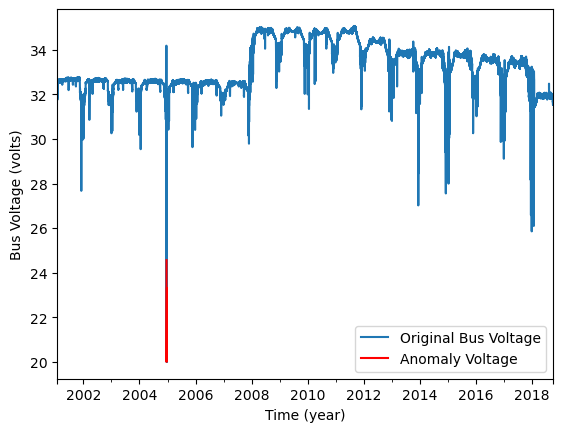

In [27]:
if len(anomalous_data_indices) > 0:
    df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
    df_subset.columns=["Anomaly Voltage"]
    df_daily_jumpsup.columns=["Original Bus Voltage"]
    fig, ax = plt.subplots()
    df_daily_jumpsup.plot(ax=ax) # removed legend=False
    df_subset.plot(ax=ax, color="r")
    plt.legend()
    plt.ylabel("Bus Voltage (volts)")
    plt.xlabel("Time (year)")
    plt.show()

    
    
    

In [28]:
from tensorflow.keras.models import load_model

model.save('my_model')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [29]:
anomalous_data_indices

[11413, 11414, 11415, 11416, 11454]

In [30]:
df_subset

,Anomaly Voltage
datetime,
2004-12-18 12:00:00,24.564687
2004-12-18 15:00:00,23.043125
2004-12-18 18:00:00,21.521562
2004-12-18 21:00:00,20.000000
2004-12-23 15:00:00,23.290167


In [31]:
np.where(anomalies)

(array([11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414,
        11415, 11447, 11448, 11449, 11450, 11451, 11452, 11453]),)